In [1]:
# Python Imports
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tensorflow General Imports
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.experimental import AdamW
# Tensorflow Pretrained Model Specific Imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19 as PretrainedCNNModel, preprocess_input

from tensorflow.keras.preprocessing import image

2024-06-11 06:50:36.859775: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Establishing Hyperparameters

In [2]:
BATCH_SIZE = 64
EPOCHS =50
LEARNING_RATE = 0.0001
IMAGE_SIZE = [224, 224]

# Loading 525 Bird Species Dataset from Kaggle

In [3]:
training_data_path = "./Data/train"
valid_data_path = "./Data/valid"

In [4]:
# Data comes from "https://www.kaggle.com/datasets/gpiosenka/100-bird-species"
train_images = glob(training_data_path + '/*/*.jpg')
valid_images = glob(valid_data_path + '/*/*.jpg')

In [5]:
folders = glob(training_data_path + '/*')
folders

['./Data/train/AMERICAN KESTREL',
 './Data/train/SCARLET IBIS',
 './Data/train/MASKED BOOBY',
 './Data/train/HARLEQUIN DUCK',
 './Data/train/HARLEQUIN QUAIL',
 './Data/train/ASIAN DOLLARD BIRD',
 './Data/train/BLACK COCKATO',
 './Data/train/BLACK SWAN',
 './Data/train/GREEN BROADBILL',
 './Data/train/EURASIAN GOLDEN ORIOLE',
 './Data/train/ANTILLEAN EUPHONIA',
 './Data/train/AMETHYST WOODSTAR',
 './Data/train/GREEN JAY',
 './Data/train/GRANDALA',
 './Data/train/BLACK THROATED BUSHTIT',
 './Data/train/CHINESE POND HERON',
 './Data/train/CALIFORNIA GULL',
 './Data/train/RED FACED CORMORANT',
 './Data/train/GRAY KINGBIRD',
 './Data/train/VULTURINE GUINEAFOWL',
 './Data/train/TIT MOUSE',
 './Data/train/MILITARY MACAW',
 './Data/train/MARABOU STORK',
 './Data/train/FAIRY BLUEBIRD',
 './Data/train/DARJEELING WOODPECKER',
 './Data/train/STRIATED CARACARA',
 './Data/train/LESSER ADJUTANT',
 './Data/train/CAATINGA CACHOLOTE',
 './Data/train/FAN TAILED WIDOW',
 './Data/train/BUFFLEHEAD',
 './Dat

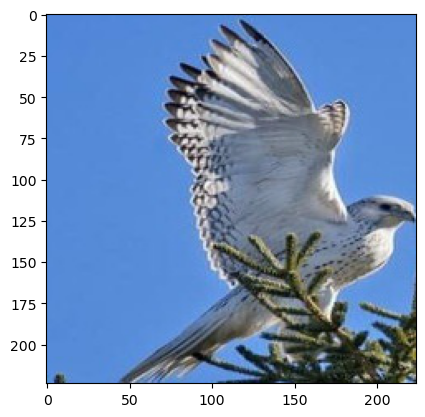

In [6]:
# look at an image for fun
plt.imshow(image.load_img(np.random.choice(train_images)))
plt.show()

# Loading in the pretrained model with ImageNet weights and Image Size

In [7]:
pretrained_model = PretrainedCNNModel(
    input_shape=IMAGE_SIZE + [3],
    include_top=False,
    weights="imagenet"
)

2024-06-11 06:50:38.177518: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-11 06:50:38.199465: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-11 06:50:38.199649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Setting VGG19 Weights as Not Trainable

In [8]:
pretrained_model.trainable = False

# Creating Our Outputs Layers

In [9]:
K = len(folders)
x = Flatten()(pretrained_model.output)
# x = Dense(1024, activation='relu')(x)
# x = Dense(512, activation='relu')(x)
# x = Dense(256, activation='relu')(x)
x = Dense(K, activation='softmax')(x)

# Creating the model with the VGG19 Pretrained Model and Custom Output Layers

In [10]:
model = Model(inputs=pretrained_model.input, outputs=x)

# Providing a Summary of the "new" model

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Creating Object to Perform Augmentation

In [12]:
get_train_images = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode="nearest",
    preprocessing_function=preprocess_input
)

# Creating a Generators for Training and Validation

In [13]:
train_generator = get_train_images.flow_from_directory(
    training_data_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

valid_generator = get_train_images.flow_from_directory(
    valid_data_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


# Compiling VGG19 with new output layers

In [14]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)

# Setting Early Stopping Once Accuracy Stops Improving

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.05,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=95,
    restore_best_weights=True,
    start_from_epoch=15
)

# Setting Model Checkpoint Saving

In [16]:
checkpoint_filepath = './VGG19_Checkpoints/checkpoint.model.keras'

In [17]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq=13230,
)

# Fitting New Output Layers to Dataset

In [18]:
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=EPOCHS,
  steps_per_epoch=int(np.ceil(len(train_images) / BATCH_SIZE)),
  validation_steps=int(np.ceil(len(valid_images) / BATCH_SIZE)),
  callbacks=[model_checkpoint_callback]
)

Epoch 1/50


2024-06-11 06:50:41.485349: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-06-11 06:50:42.592024: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-11 06:50:42.622892: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x8d27d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-11 06:50:42.622912: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-06-11 06:50:42.627240: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-11 06:50:42.727967: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proces

1323/1323 [==============================] - 511s 384ms/step - loss: 4.5255 - accuracy: 0.2184 - val_loss: 1.7796 - val_accuracy: 0.5752
Epoch 2/50
1323/1323 [==============================] - 512s 387ms/step - loss: 1.4462 - accuracy: 0.6567 - val_loss: 1.0521 - val_accuracy: 0.7402
Epoch 3/50
1323/1323 [==============================] - 511s 386ms/step - loss: 0.8471 - accuracy: 0.7828 - val_loss: 0.9329 - val_accuracy: 0.7764
Epoch 4/50
1323/1323 [==============================] - 515s 389ms/step - loss: 0.6083 - accuracy: 0.8384 - val_loss: 0.8284 - val_accuracy: 0.8038
Epoch 5/50
1323/1323 [==============================] - 516s 390ms/step - loss: 0.4661 - accuracy: 0.8718 - val_loss: 0.7928 - val_accuracy: 0.8221
Epoch 6/50
1323/1323 [==============================] - 511s 386ms/step - loss: 0.3826 - accuracy: 0.8941 - val_loss: 0.8238 - val_accuracy: 0.8240
Epoch 7/50
1323/1323 [==============================] - 512s 387ms/step - loss: 0.3313 - accuracy: 0.9089 - val_loss: 0.823

In [19]:
model.save("VGG_19_Bird_500_Epochs")

INFO:tensorflow:Assets written to: VGG_19_Bird_100_Epochs/assets


INFO:tensorflow:Assets written to: VGG_19_Bird_100_Epochs/assets


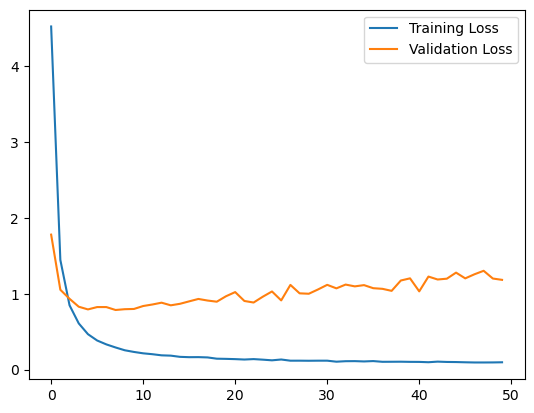

In [20]:
plt.plot(r.history['loss'], label='Training Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

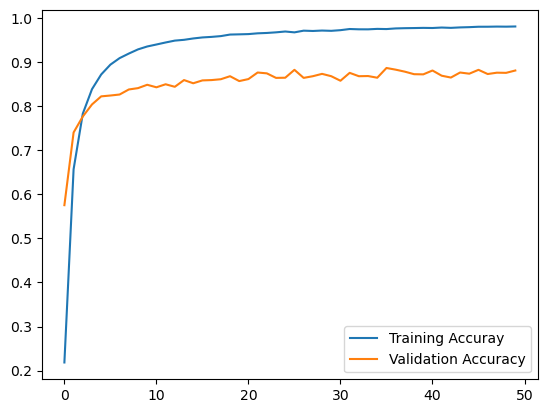

In [21]:
plt.plot(r.history['accuracy'], label='Training Accuray')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()